In [105]:
import pandas as pd
import numpy as np

df = pd.read_csv("MEco.csv", index_col=0)
df.head()


,mean_brent_oil_prices(USD/barrel),sum_brent_oil_prices(USD/barrel),volatilite_brent_oil_prices(USD/barrel),mean_crude_oil_prices(USD/barrel),sum_crude_oil_prices(USD/barrel),volatilite_crude_oil_prices(USD/barrel),mean_daily_natural_gas_prices(USD/MMBtu),sum_daily_natural_gas_prices(USD/MMBtu),volatilite_daily_natural_gas_prices(USD/MMBtu),IDE(USD),...,wheat_production (Million Bushels),InterTourismeReceipts(usd),Consommation finals des ménages,Dépenses nationales brutes (unités de devises locales courantes),Exportation de biens et de services ($ US),Importation de bien et de services ($ US),Pauvrete,Analphabetisme,Demographie,event
1985,0.000000,0.00,0.000000,27.873335,334.48,1.315504,0.0,0.0,0.0,19975166.0,...,2424.115,0.0,9.057385e+09,1.633613e+11,3.824760e+09,5.067331e+09,23.0,62.0,55393.0,0.0
1986,0.000000,0.00,0.000000,14.413334,172.96,2.470161,0.0,0.0,0.0,549182.5,...,2090.570,0.0,1.192824e+10,1.887370e+11,4.258765e+09,5.526889e+09,22.0,61.0,55661.0,0.0
1987,7.684166,92.21,9.500925,19.036667,228.44,1.370676,0.0,0.0,0.0,59574900.0,...,2107.685,0.0,1.330800e+10,1.904822e+11,4.893089e+09,5.914964e+09,21.0,60.0,55947.0,0.0
1988,9.785000,117.42,7.307772,15.974167,191.69,1.493309,0.0,0.0,0.0,84661624.0,...,1812.201,0.0,1.494788e+10,2.113223e+11,6.425436e+09,6.462583e+09,20.0,59.0,56250.0,0.0
1989,10.266666,123.20,9.100613,19.573334,234.88,1.276510,0.0,0.0,0.0,167056030.0,...,2036.618,0.0,1.516464e+10,2.350670e+11,5.935177e+09,7.314302e+09,18.0,58.5,56560.0,0.0


In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, mse

In [109]:
# Conversion de l'index en datetime en utilisant l'année comme index
df.index = pd.to_datetime(df.index, format='%Y')

# Sélection des variables d'intérêt pour le modèle VAR
# Je choisis des variables économiques pertinentes qui semblent complètes
selected_vars = [
    'IDE(USD)',
    'mean_crude_oil_prices(USD/barrel)',
    'volatilite_crude_oil_prices(USD/barrel)',
    'InterTourismeReceipts(usd)',
    'Consommation finals des ménages',
    'Dépenses nationales brutes (unités de devises locales courantes)',
    'Exportation de biens et de services ($ US)',
    'Importation de bien et de services ($ US)',
    'Demographie',
    'event'
]

# Filtrage des données pour ne garder que les colonnes sélectionnées
df_var = df[selected_vars].copy()

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
print(df_var.isna().sum())



Valeurs manquantes par colonne:
IDE(USD)                                                            0
mean_crude_oil_prices(USD/barrel)                                   0
volatilite_crude_oil_prices(USD/barrel)                             0
InterTourismeReceipts(usd)                                          0
Consommation finals des ménages                                     0
Dépenses nationales brutes (unités de devises locales courantes)    0
Exportation de biens et de services ($ US)                          0
Importation de bien et de services ($ US)                           0
Demographie                                                         0
event                                                               0
dtype: int64


In [111]:
# Fonction pour détecter les outliers avec IQR
def detect_outliers(df):
    outliers_dict = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if not outliers.empty:
            outliers_dict[col] = outliers
    
    return outliers_dict

In [113]:
# Détection des outliers
outliers = detect_outliers(df_var)
print("\nOutliers détectés:")
for col, values in outliers.items():
    print(f"{col}: {len(values)} outliers")
    print(values)

# Traitement des outliers (remplacement par la limite IQR)
for col in df_var.columns:
    Q1 = df_var[col].quantile(0.25)
    Q3 = df_var[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remplacement des outliers par les limites
    df_var.loc[df_var[col] < lower_bound, col] = lower_bound
    df_var.loc[df_var[col] > upper_bound, col] = upper_bound


Outliers détectés:
volatilite_crude_oil_prices(USD/barrel): 2 outliers
2008-01-01    29.511637
2014-01-01    16.332610
Name: volatilite_crude_oil_prices(USD/barrel), dtype: float64
event: 11 outliers
1993-01-01    0.218562
1995-01-01   -0.254192
1999-01-01   -0.081611
2000-01-01    0.456048
2004-01-01    0.254192
2007-01-01   -0.485709
2010-01-01    0.500000
2011-01-01   -0.138368
2019-01-01    0.254192
2020-01-01   -0.709072
2021-01-01   -0.540554
Name: event, dtype: float64


In [115]:

# Fonction pour vérifier la stationnarité (test ADF)
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # Si p-value < 0.05, la série est stationnaire
    if result[1] <= 0.05:
        print("=> Série stationnaire")
        return True
    else:
        print("=> Série non stationnaire")
        return False

# Vérification de la stationnarité pour chaque variable
print("\nTests de stationnarité:")
stationary_status = {}
for col in df_var.columns:
    print(f"\nTest ADF pour {col}")
    stationary_status[col] = adf_test(df_var[col])

# Différenciation des séries non stationnaires
df_var_diff = df_var.copy()
diff_order = {}

for col in df_var.columns:
    if not stationary_status[col]:
        # Essayer différenciation d'ordre 1
        df_var_diff[col] = df_var[col].diff().dropna()
        print(f"\nTest ADF après différenciation d'ordre 1 pour {col}")
        stationary_1 = adf_test(df_var_diff[col].dropna())
        
        if stationary_1:
            diff_order[col] = 1
        else:
            # Essayer différenciation d'ordre 2
            df_var_diff[col] = df_var[col].diff().diff().dropna()
            print(f"\nTest ADF après différenciation d'ordre 2 pour {col}")
            stationary_2 = adf_test(df_var_diff[col].dropna())
            diff_order[col] = 2 if stationary_2 else 0
    else:
        diff_order[col] = 0



Tests de stationnarité:

Test ADF pour IDE(USD)
ADF Statistic: -1.6221
p-value: 0.4716
Critical Values:
	1%: -3.6327
	5%: -2.9485
	10%: -2.6130
=> Série non stationnaire

Test ADF pour mean_crude_oil_prices(USD/barrel)
ADF Statistic: -1.4005
p-value: 0.5820
Critical Values:
	1%: -3.6267
	5%: -2.9460
	10%: -2.6117
=> Série non stationnaire

Test ADF pour volatilite_crude_oil_prices(USD/barrel)
ADF Statistic: -3.1016
p-value: 0.0264
Critical Values:
	1%: -3.6267
	5%: -2.9460
	10%: -2.6117
=> Série stationnaire

Test ADF pour InterTourismeReceipts(usd)
ADF Statistic: -1.2340
p-value: 0.6588
Critical Values:
	1%: -3.6267
	5%: -2.9460
	10%: -2.6117
=> Série non stationnaire

Test ADF pour Consommation finals des ménages
ADF Statistic: 0.5422
p-value: 0.9861
Critical Values:
	1%: -3.6267
	5%: -2.9460
	10%: -2.6117
=> Série non stationnaire

Test ADF pour Dépenses nationales brutes (unités de devises locales courantes)
ADF Statistic: 1.7809
p-value: 0.9983
Critical Values:
	1%: -3.6327
	5%: 

ValueError: Invalid input, x is constant

In [ ]:
# Préparation des données pour le modèle VAR
# Pour éviter les problèmes avec les indices, réinitialisons l'index
df_var_diff = df_var_diff.dropna()

print("\nOrdre de différenciation pour chaque variable:")
for col, order in diff_order.items():
    print(f"{col}: {order}")


# Visualisation compacte et lisible des séries différenciées
n_cols = 2  # Nombre de colonnes de graphiques
n_rows = int(np.ceil(len(df_var_diff.columns) / n_cols))  # Calcul automatique des lignes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Pour un accès facile via un seul indice

for i, col in enumerate(df_var_diff.columns):
    axes[i].plot(df_var_diff[col], label=col)
    axes[i].set_title(f"Série différenciée : {col}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

# Si des sous-graphiques restent vides (ex: nombre impair), on les cache
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Visualisation des séries différenciées", fontsize=16)
plt.show()


In [118]:

# Pour garantir que toutes les séries sont de même longueur
print("\nDimensions des données différenciées:")
print(df_var_diff.shape)



Dimensions des données différenciées:
(35, 10)



--- Construction du modèle VAR ---

Sélection de l'ordre de retard optimal:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       276.1      276.5*  8.359e+119       276.3
1       272.5       276.5  2.546e+118       273.8
2      269.9*       277.7 7.014e+117*      272.5*
-------------------------------------------------

Ordre de retard optimal retenu: 2

Résumé du modèle VAR:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, May, 2025
Time:                     23:15:57
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    277.659
Nobs:                     33.0000    HQIC:                   272.514
Log likelihood:          -4703.85    FPE:               7.01401e+117
AIC:                      269.904    Det(Omega_mle):    1.17101e

C:\Users\khali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


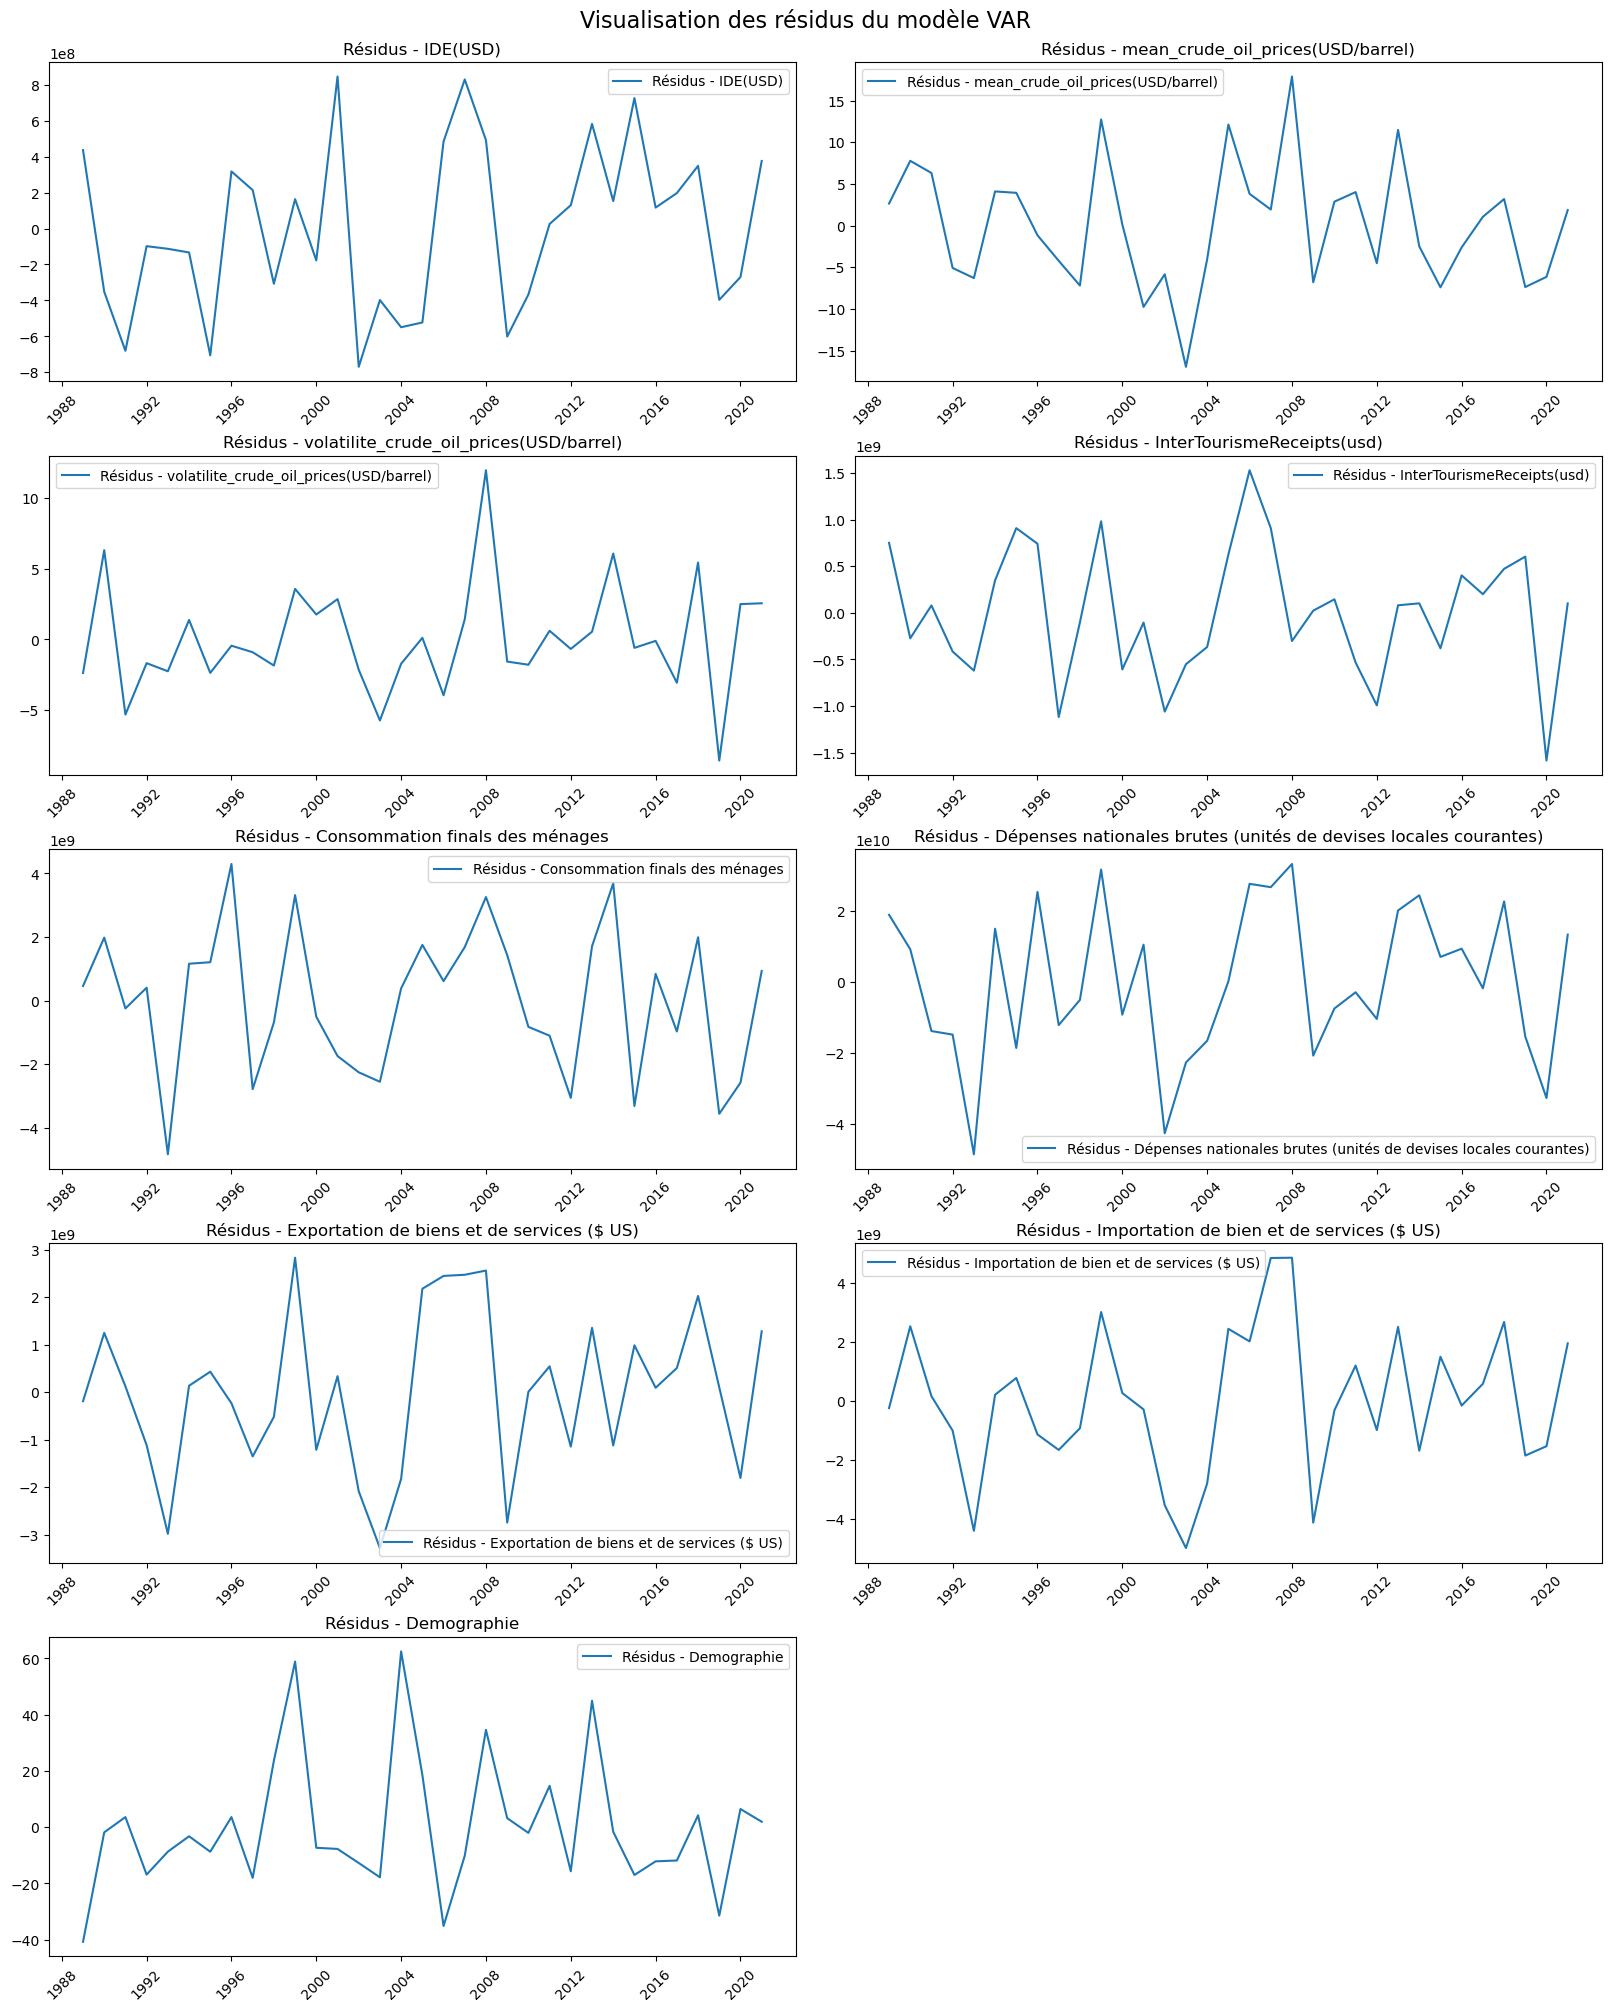

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

# Renommer df_var_diff.iloc[:, :-1] par df_etudie
df_etudie = df_var_diff.iloc[:, :-1]

# Construction du modèle VAR
print("\n--- Construction du modèle VAR ---")

# Création du modèle VAR
model = VAR(df_etudie)

# Sélection automatique du lag_order optimal
lag_order_results = model.select_order(maxlags=2)
print("\nSélection de l'ordre de retard optimal:")
print(lag_order_results.summary())

# Choix de l'ordre de retard optimal (AIC)
optimal_lag = lag_order_results.aic

# Si l'optimal_lag est trop élevé par rapport au nombre d'observations,
# nous pouvons le limiter à une valeur raisonnable
n_obs = len(df_etudie)
if optimal_lag > n_obs / 5:  # Règle empirique pour éviter le surajustement
    optimal_lag = int(n_obs / 5)

print(f"\nOrdre de retard optimal retenu: {optimal_lag}")

# Ajustement du modèle avec le lag_order optimal
var_model = model.fit(optimal_lag,df_var_diff.iloc[:, -1])

print("\nRésumé du modèle VAR:")
print(var_model.summary())

# Vérification des résidus
residuals = var_model.resid

# Vérifiez les dimensions de residuals
print("\nDimensions des résidus:", residuals.shape)

# Test de Durbin-Watson pour l'autocorrélation des résidus
print("\nTest de Durbin-Watson pour l'autocorrélation des résidus:")
for i, col in enumerate(df_etudie.columns):
    if i < residuals.shape[1]:  # Assurez-vous que l'indice est valide
        print(f"{col}: {durbin_watson(residuals.iloc[:, i])}")

# Visualisation des résidus de manière compacte et lisible
n_cols = 2  # Nombre de colonnes de graphiques
n_rows = int(np.ceil(len(df_etudie.columns) / n_cols))  # Calcul automatique des lignes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Pour un accès facile via un seul indice

for i, col in enumerate(df_etudie.columns):
    if i < residuals.shape[1]:  # Assurez-vous que l'indice est valide
        axes[i].plot(residuals.iloc[:, i], label=f"Résidus - {col}")
        axes[i].set_title(f"Résidus - {col}", fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend()

# Si des sous-graphiques restent vides (ex: nombre impair), on les cache
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Visualisation des résidus du modèle VAR", fontsize=16)
plt.show()


In [121]:

# Définition de l'horizon de prévision (5 ans)
forecast_horizon = 5

# Prévisions
forecast = var_model.forecast(y=df_etudie.values, steps=forecast_horizon)
forecast_index = pd.date_range(start=df_var_diff.index[-1], periods=forecast_horizon+1, freq='Y')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df_etudie.columns)

print("\nPrévisions pour les 5 prochaines années:")
print(forecast_df)



Prévisions pour les 5 prochaines années:
                IDE(USD)  mean_crude_oil_prices(USD/barrel)  \
2022-12-31 -1.118370e+09                         -66.504493   
2023-12-31  1.824474e+09                          44.537616   
2024-12-31 -1.025812e+09                         -47.197204   
2025-12-31  8.186142e+08                           5.104763   
2026-12-31 -1.851754e+09                         -24.468038   

            volatilite_crude_oil_prices(USD/barrel)  \
2022-12-31                                -9.523069   
2023-12-31                                -2.077128   
2024-12-31                                 1.579221   
2025-12-31                                 5.015246   
2026-12-31                                 2.643466   

            InterTourismeReceipts(usd)  Consommation finals des ménages  \
2022-12-31               -4.910274e+09                    -1.563802e+10   
2023-12-31                1.855322e+09                     1.039611e+10   
2024-12-31             

C:\Users\khali\AppData\Local\Temp\ipykernel_21060\588116128.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=df_var_diff.index[-1], periods=forecast_horizon+1, freq='Y')[1:]


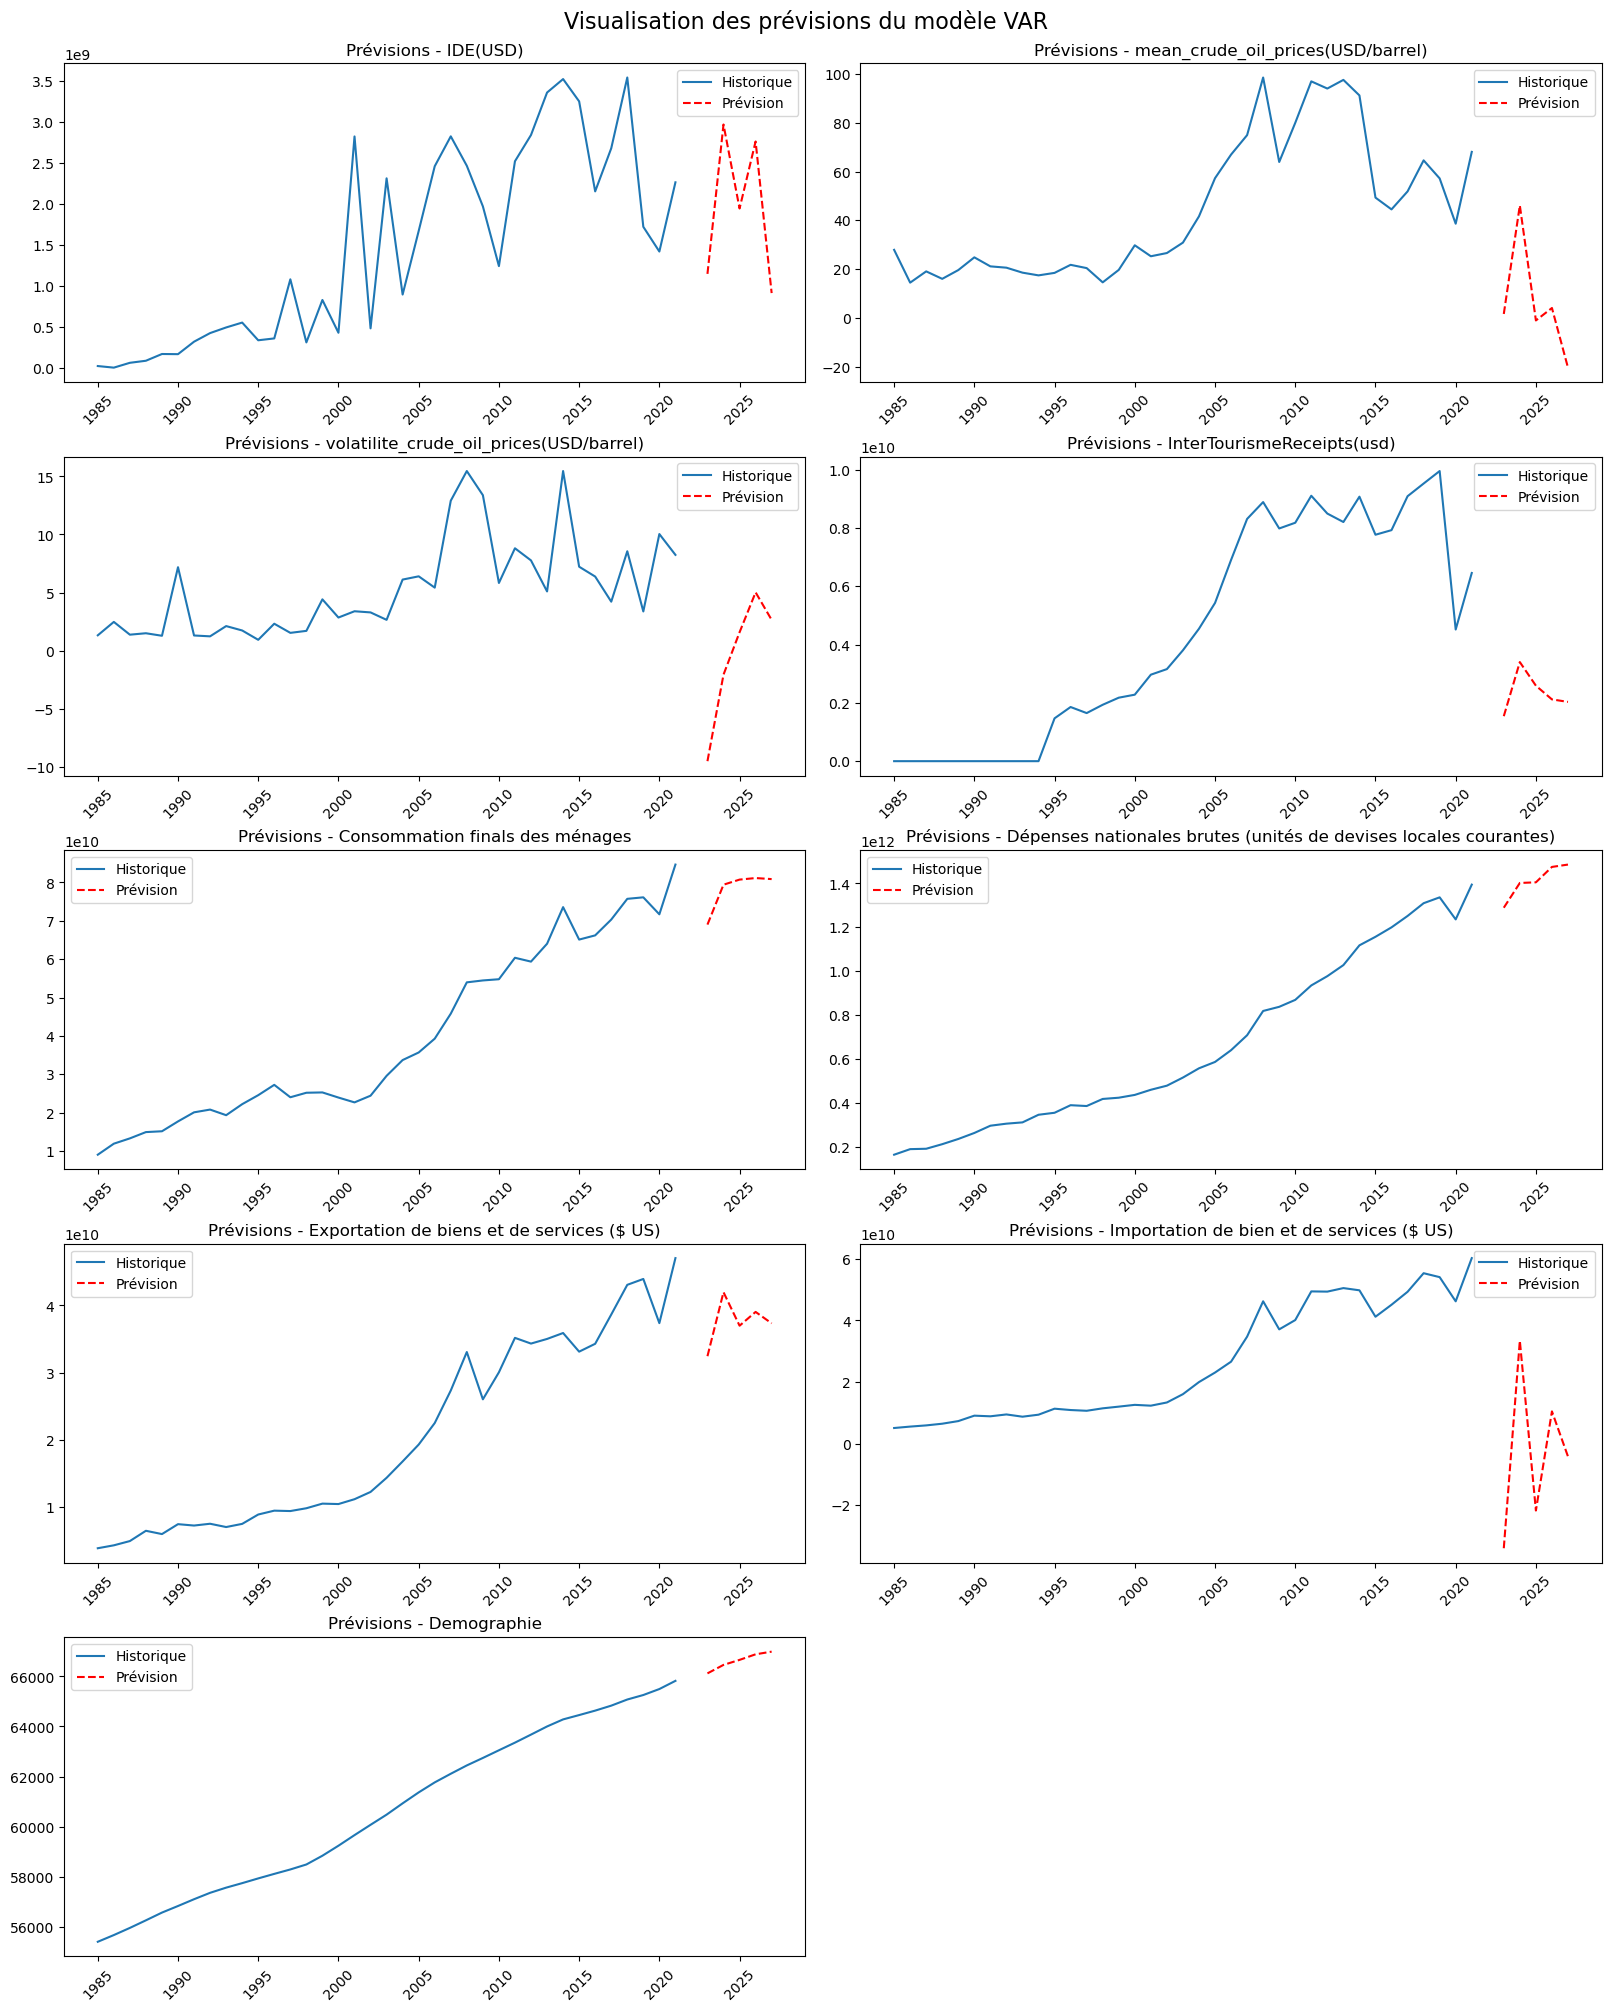

In [122]:
# Convertir les prévisions différenciées en niveaux (inverse de la différenciation)
forecast_levels = {}

for col in df_etudie.columns:
    # Récupérer la dernière valeur observée
    last_value = df_var[col].iloc[-1]
    
    # Si la série a été différenciée (ordre 1)
    if diff_order[col] == 1:
        levels = np.concatenate([[last_value], last_value + np.cumsum(forecast_df[col].values)])
    # Si la série a été différenciée (ordre 2)
    elif diff_order[col] == 2:
        last_diff = df_var[col].diff().iloc[-1]
        levels = [last_value]
        for i in range(forecast_horizon):
            next_diff = last_diff + forecast_df[col].iloc[i]
            next_value = levels[-1] + next_diff
            levels.append(next_value)
            last_diff = next_diff
        levels = np.array(levels)
    # Si la série n'a pas été différenciée
    else:
        levels = np.concatenate([[last_value], forecast_df[col].values])
    
    forecast_levels[col] = levels[1:]  # Exclure la dernière valeur observée

# Créer un DataFrame pour les prévisions en niveaux
forecast_levels_df = pd.DataFrame(forecast_levels, index=forecast_index)

# Visualisation des prévisions pour chaque variable de manière compacte et lisible
n_cols = 2  # Nombre de colonnes de graphiques
n_rows = int(np.ceil(len(df_etudie.columns) / n_cols))  # Calcul automatique des lignes (en fonction de df_etudie)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Pour un accès facile via un seul indice

# Boucle pour afficher chaque graphique
for i, col in enumerate(df_etudie.columns):  # Utilisation de df_etudie.columns
    axes[i].plot(df_var.index, df_var[col], label='Historique')
    axes[i].plot(forecast_levels_df.index, forecast_levels_df[col], 'r--', label='Prévision')
    axes[i].set_title(f"Prévisions - {col}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

# Si des sous-graphiques restent vides (ex: nombre impair), on les cache
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Visualisation des prévisions du modèle VAR", fontsize=16)
plt.show()


C:\Users\khali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)



Erreurs de prévision par variable:
IDE(USD):
  RMSE: 2614457930.5014
  MSE: 6835390270361499648.0000
mean_crude_oil_prices(USD/barrel):
  RMSE: 20.6887
  MSE: 428.0220
volatilite_crude_oil_prices(USD/barrel):
  RMSE: 11.4976
  MSE: 132.1956
InterTourismeReceipts(usd):
  RMSE: 2232487107.4235
  MSE: 4983998684812129280.0000
Consommation finals des ménages:
  RMSE: 8226551067.4470
  MSE: 67676142465313144832.0000
Dépenses nationales brutes (unités de devises locales courantes):
  RMSE: 85219928738.0874
  MSE: 7262436254124690374656.0000
Exportation de biens et de services ($ US):
  RMSE: 4035217415.3668
  MSE: 16282979589279303680.0000
Importation de bien et de services ($ US):
  RMSE: 7203922546.6217
  MSE: 51896500057723887616.0000
Demographie:
  RMSE: 78.0467
  MSE: 6091.2914
event:
  RMSE: 0.7605
  MSE: 0.5783

--- Test de causalité de Granger ---

Dans quelle mesure l'incertitude sur une variable (ex. : PIB) est-elle causée par ses propres chocs, ou par ceux des autres variables (e

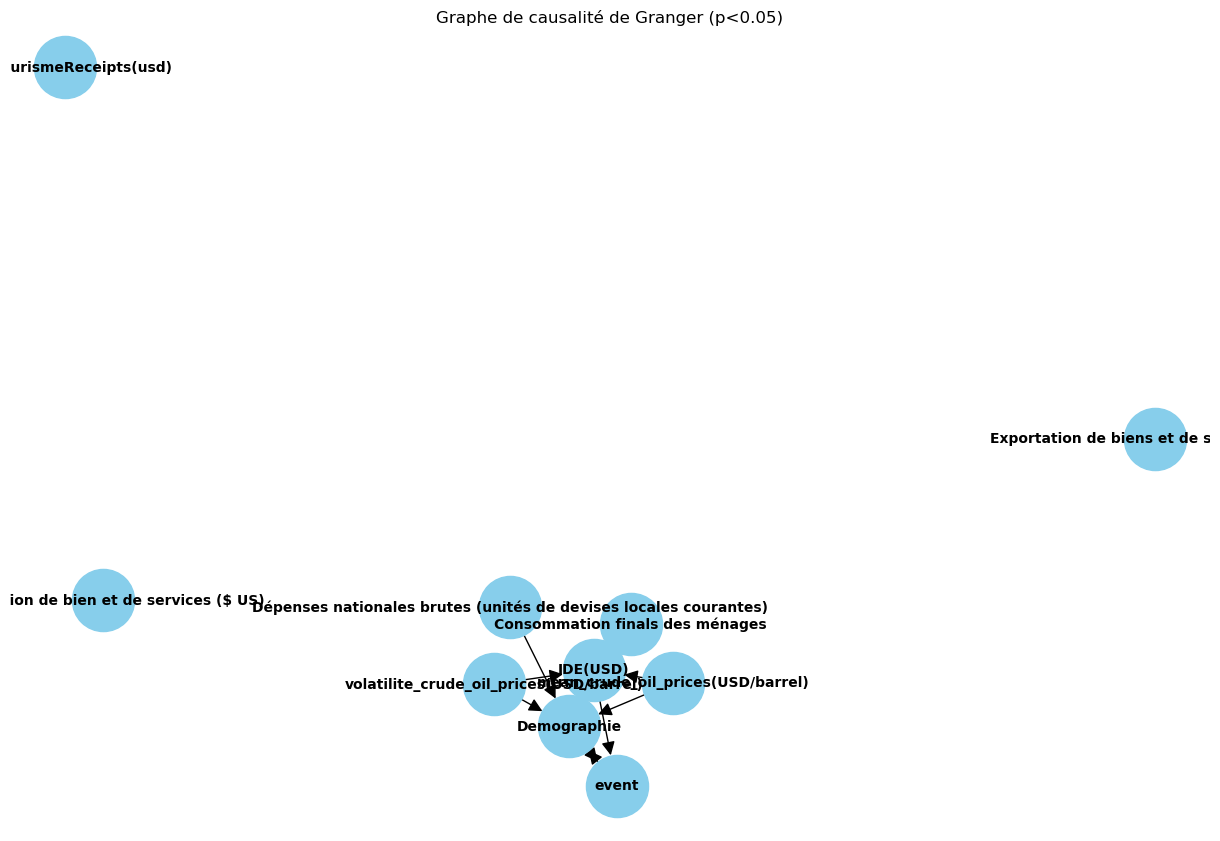

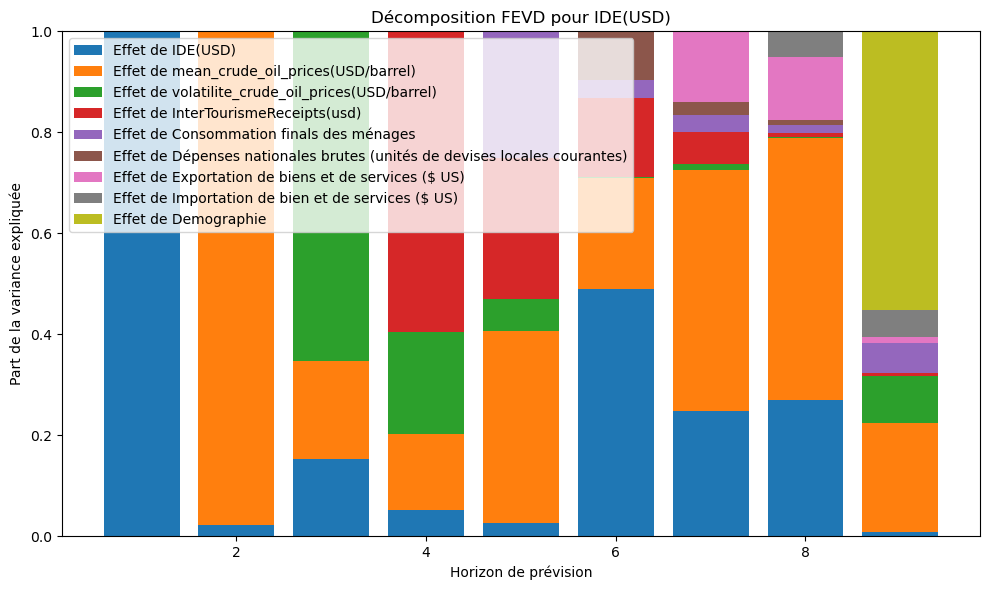

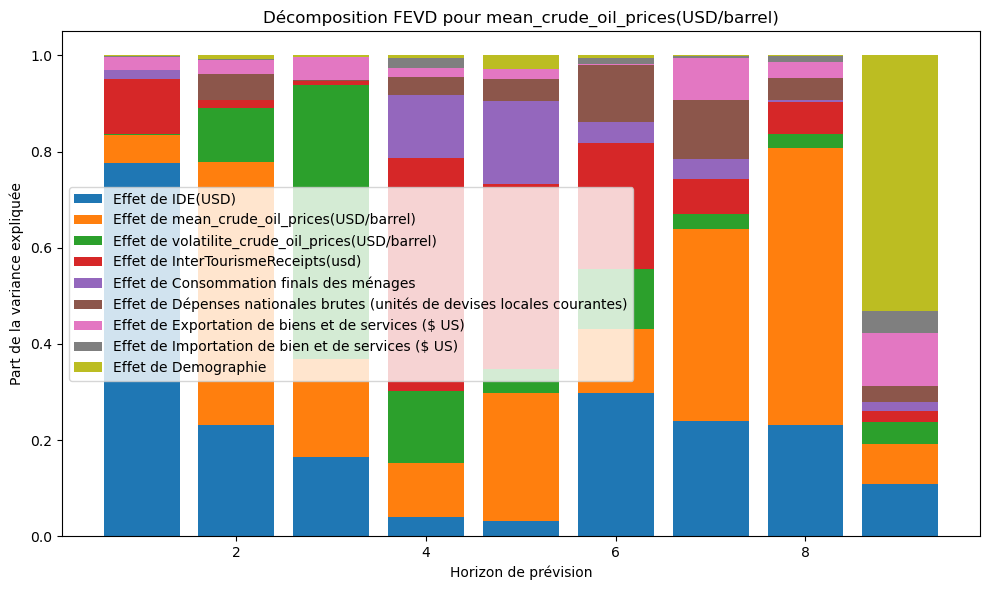

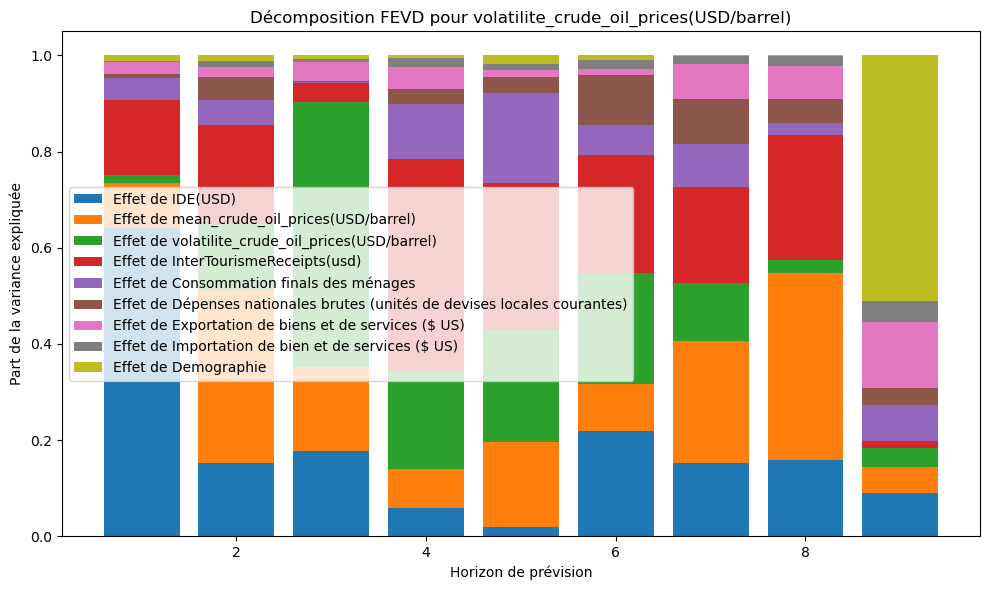

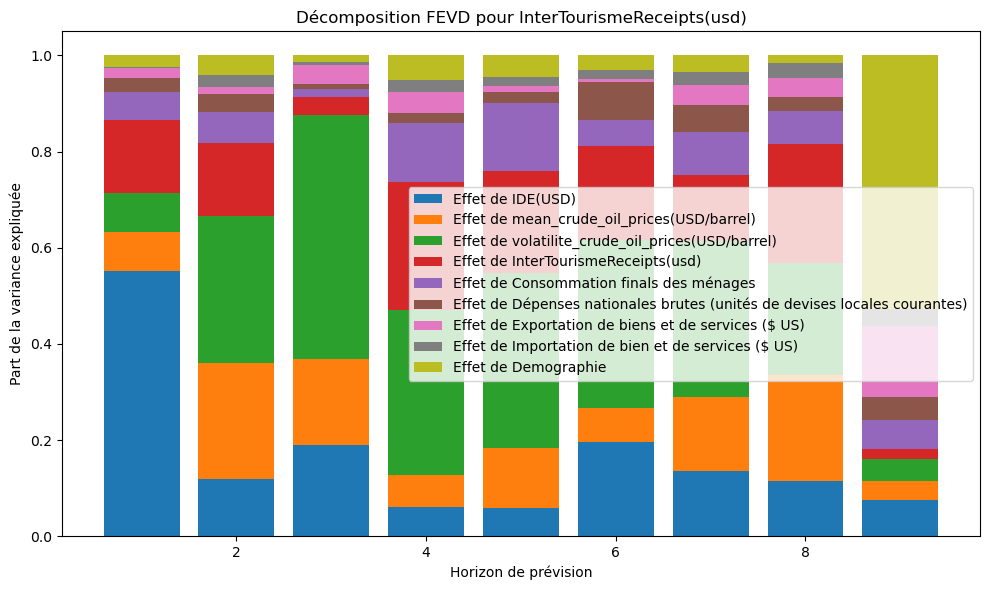

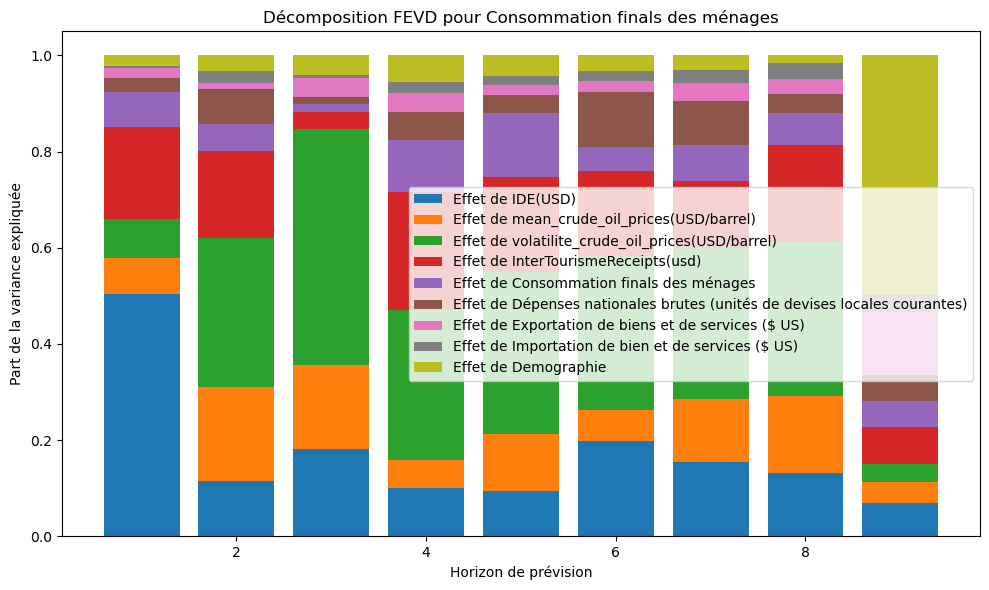

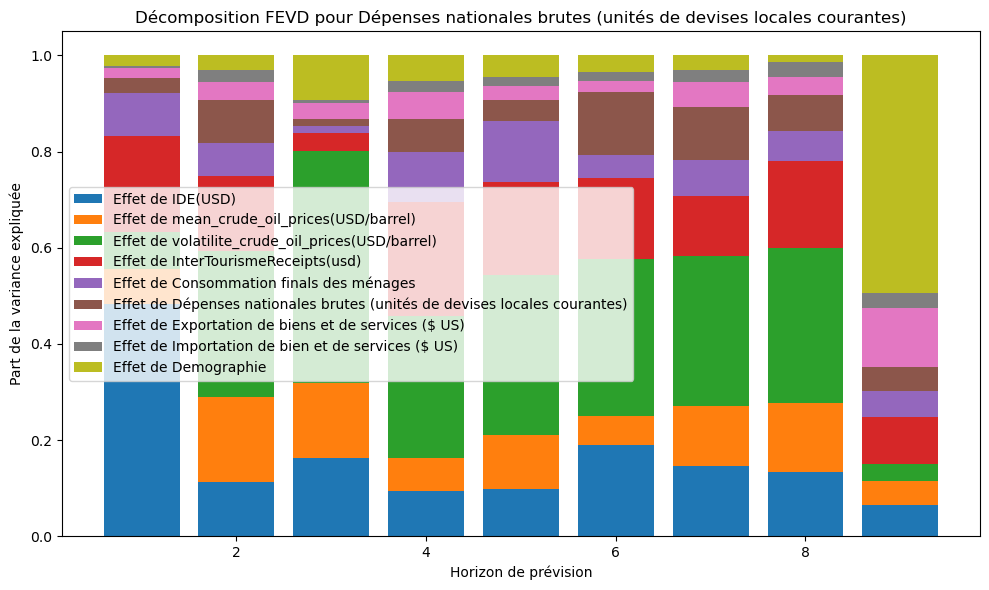

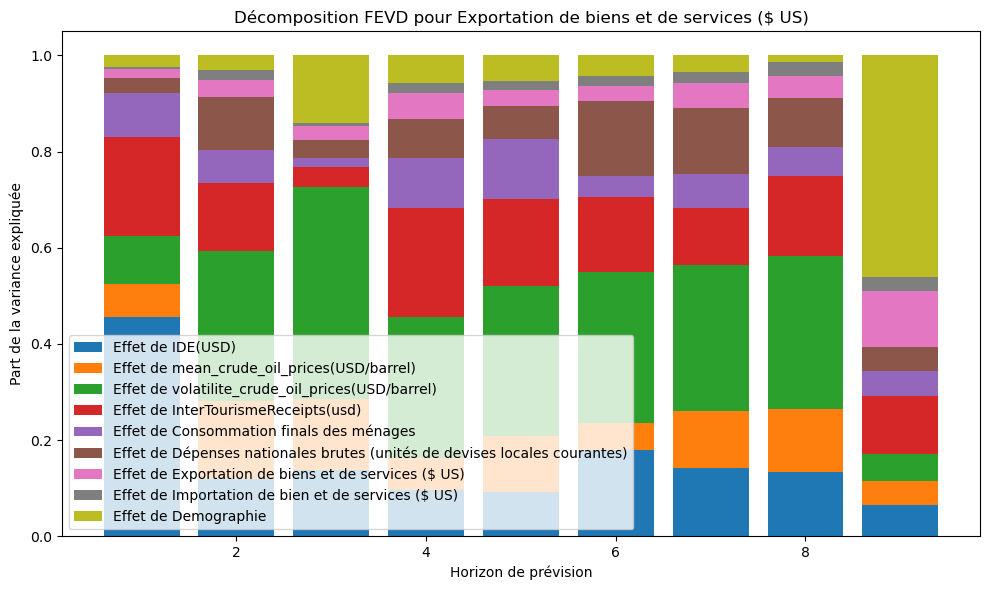

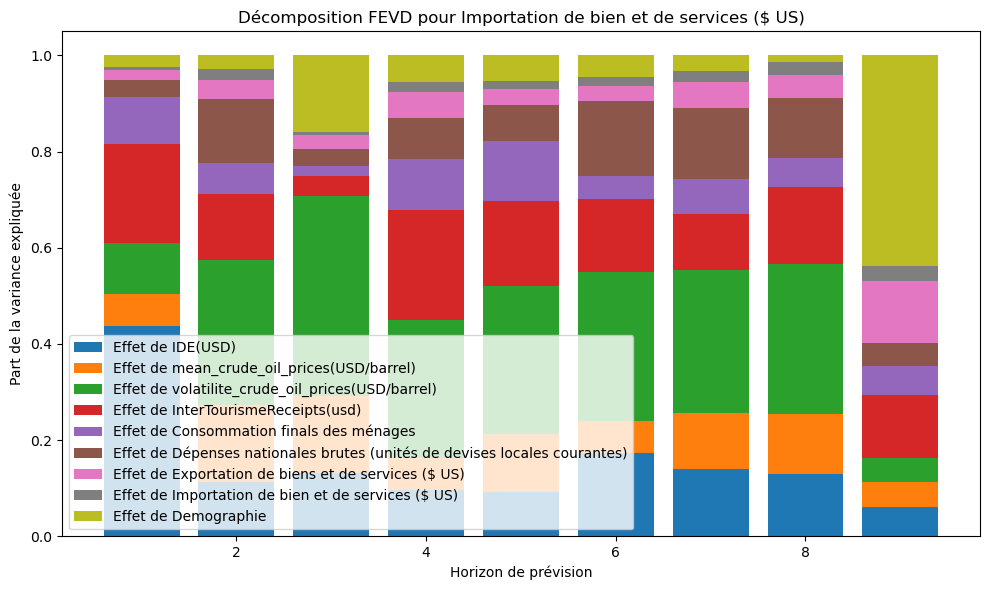

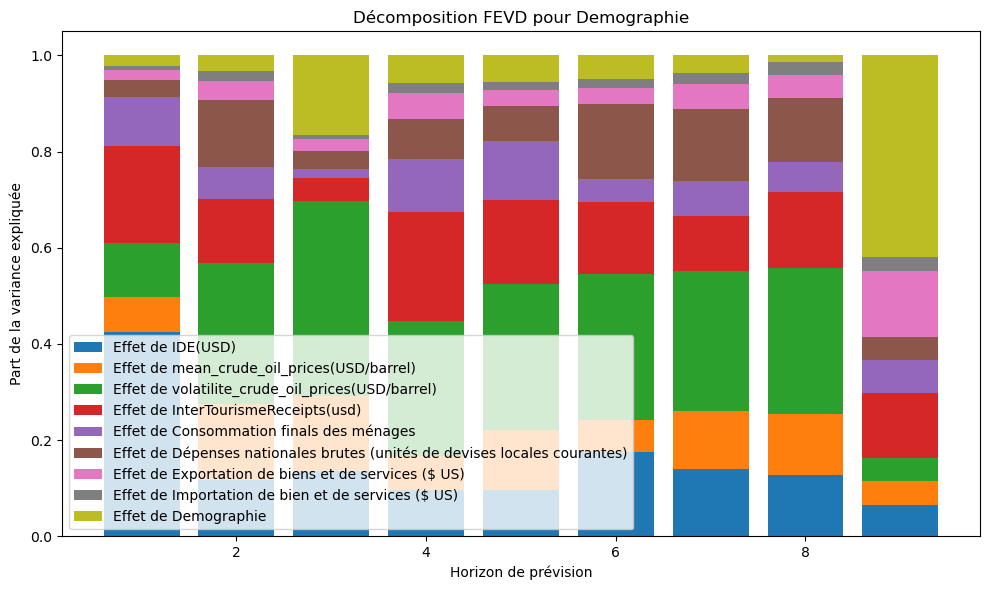


Analyse VAR complète terminée.


In [142]:

# Analyse des erreurs de prévision
# Pour une analyse des erreurs out-of-sample, on utiliserait idéalement une période de test
# Mais sans données supplémentaires, nous pouvons faire une prévision in-sample et calculer les erreurs

# Prévision in-sample pour évaluer la performance du modèle
n_obs = len(df_var_diff)
train_size = int(n_obs * 0.8)  # 80% pour l'entraînement
train_data = df_var_diff.iloc[:train_size]
test_data = df_var_diff.iloc[train_size:]

# Ajustement du modèle sur les données d'entraînement
var_train = VAR(train_data).fit(optimal_lag)

# Prévision sur la période de test
forecast_steps = len(test_data)
forecast_in_sample = var_train.forecast(y=train_data.values[-optimal_lag:], steps=forecast_steps)
forecast_in_sample_df = pd.DataFrame(forecast_in_sample, index=test_data.index, columns=test_data.columns)

# Calcul des erreurs
errors = {}
for col in test_data.columns:
    rmse_val = rmse(test_data[col].values, forecast_in_sample_df[col].values)
    mse_val = mse(test_data[col].values, forecast_in_sample_df[col].values)
    errors[col] = {'RMSE': rmse_val, 'MSE': mse_val}

print("\nErreurs de prévision par variable:")
for col, err in errors.items():
    print(f"{col}:")
    print(f"  RMSE: {err['RMSE']:.4f}")
    print(f"  MSE: {err['MSE']:.4f}")

# 4. Analyse de causalité de Granger
print("\n--- Test de causalité de Granger ---")

# Test de causalité de Granger pour toutes les paires de variables
max_lag = min(10, int(len(df_var_diff) / 5))  # Limiter le nombre de lags pour éviter les problèmes
granger_results = {}

for cause in df_var_diff.columns:
    for effect in df_var_diff.columns:
        if cause != effect:  # Ne pas tester la causalité d'une variable sur elle-même
            pair = (cause, effect)
            try:
                test_result = var_train.test_causality(effect, cause, kind='f', signif=0.05)
                granger_results[pair] = {
                    'F-stat': test_result.test_statistic,
                    'p-value': test_result.pvalue,
                    'Causalité': 'Oui' if test_result.pvalue < 0.05 else 'Non'
                }
            except ValueError as e:
                print(f"Erreur pour le couple ({cause}, {effect}) : {e}")

# Affichage des résultats du test de causalité de Granger
print("\nDans quelle mesure l'incertitude sur une variable (ex. : PIB) est-elle causée par ses propres chocs, ou par ceux des autres variables (ex. : inflation, chômage) ?:")
print("\nRésultats du test de causalité de Granger:")
print("\nHypothèse: Variable 1 cause (au sens de Granger) Variable 2")
print("\n{:<40} | {:<10} | {:<10} | {:<10}".format("Relation", "F-stat", "p-value", "Causalité"))
print("-" * 75)

for pair, result in granger_results.items():
    cause, effect = pair
    print("{:<40} | {:<10.4f} | {:<10.4f} | {:<10}".format(
        f"{cause} → {effect}",
        result['F-stat'],
        result['p-value'],
        result['Causalité']
    ))

# Visualisation des relations causales significatives
causal_pairs = [(pair[0], pair[1]) for pair, result in granger_results.items() if result['Causalité'] == 'Oui']

# Si nous avons des relations causales, créons un graphe de causalité
if causal_pairs:
    try:
        import networkx as nx
        
        # Création du graphe dirigé
        G = nx.DiGraph()
        
        # Ajout des nœuds (variables)
        for col in df_var_diff.columns:
            G.add_node(col)
        
        # Ajout des arêtes (relations causales)
        for cause, effect in causal_pairs:
            G.add_edge(cause, effect)
        
        # Visualisation du graphe
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=42)  # Layout pour le graphe
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, 
                arrowsize=20, font_size=10, font_weight='bold')
        plt.title('Graphe de causalité de Granger (p<0.05)')
        plt.show()
        plt.close()
        
    except ImportError:
        print("\nL'installation de networkx est nécessaire pour visualiser le graphe de causalité.")

# Correction pour la partie FEVD
fevd = var_model.fevd(9)  # On utilise l'horizon correspondant à vos données (9)
contributions = fevd.decomp  # shape: (9, 5, 9) - signifie 5 variables endogènes dans le modèle

# Nombre de variables endogènes dans le modèle VAR
n_vars_model = contributions.shape[1]  # = 5

# Sélection des noms de variables correspondant aux variables endogènes du modèle
# Supposons que les 5 premières colonnes sont les variables endogènes
variable_names = df_var_diff.columns[:n_vars_model]

for i in range(n_vars_model):
    plt.figure(figsize=(10, 6))
    bottom = np.zeros(9)  # horizon=9
    for j in range(n_vars_model):
        plt.bar(
            np.arange(1, 10),  # de 1 à 9
            contributions[:, i, j],
            bottom=bottom,
            label=f"Effet de {variable_names[j]}"
        )
        bottom += contributions[:, i, j]
    plt.title(f"Décomposition FEVD pour {variable_names[i]}")
    plt.xlabel("Horizon de prévision")
    plt.ylabel("Part de la variance expliquée")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nAnalyse VAR complète terminée.")